In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Configuración visual mejorada
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("📊 ANÁLISIS EDUCATIVO COMPLETO")
print("="*50)


📊 ANÁLISIS EDUCATIVO COMPLETO


In [2]:
# === CARGA DE DATOS ===
def load_education_data():
    """Carga todos los datasets educativos"""
    data = {}
    files = {
        'education': '../downloads/normalizacion/education.csv',
        'admissions': '../downloads/normalizacion/education_admition.csv',
        'enrollment': '../downloads/normalizacion/education_enrollment.csv',
        'edu_municipality': '../downloads/normalizacion/education_municipality.csv',
        'municipality': '../downloads/normalizacion/municipality.csv'
    }

    for name, path in files.items():
        delimiter = ';' if 'education' in path and 'municipality' not in path else ','
        data[name] = pd.read_csv(path, delimiter=delimiter)
        # Convertir IDs a string
        if 'id' in data[name].columns:
            data[name]['id'] = data[name]['id'].astype(str)
        if 'id_education' in data[name].columns:
            data[name]['id_education'] = data[name]['id_education'].astype(str)
        if 'id_municipality' in data[name].columns:
            data[name]['id_municipality'] = data[name]['id_municipality'].astype(str)

    return data

data = load_education_data()
print(f"✅ Datos cargados: {[f'{k}: {len(v)}' for k, v in data.items()]}")


✅ Datos cargados: ['education: 1978', 'admissions: 39297', 'enrollment: 24159', 'edu_municipality: 2780', 'municipality: 179']


In [3]:
# === PROCESAMIENTO PRINCIPAL ===
def create_education_summary(data):
    """Crea resumen consolidado de educación por municipio"""

    # Mapeo centro-municipio con nombres
    center_map = data['edu_municipality'].merge(
        data['municipality'][['id', 'name']].rename(columns={'id': 'id_municipality', 'name': 'municipality_name'}),
        on='id_municipality'
    )

    # Filtrar datos por año específico 2022-2023 y ciclos principales
    cycles = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']
    target_year = "2022-2023"  # Año específico para el análisis

    admissions = data['admissions'][
        (data['admissions']['year'] == target_year) &
        (data['admissions']['cycle'].isin(cycles))
    ]

    enrollment = data['enrollment'][
        (data['enrollment']['year'] == target_year) &
        (data['enrollment']['cycle'].isin(cycles))
    ]

    print(f"🎯 Analizando año académico: {target_year}")
    print(f"   • Registros de admisiones: {len(admissions):,}")
    print(f"   • Registros de matrícula: {len(enrollment):,}")

    # Resumen por municipio
    summary_list = []
    for muni_id in center_map['id_municipality'].unique():
        muni_data = center_map[center_map['id_municipality'] == muni_id]
        muni_name = muni_data['municipality_name'].iloc[0]
        centers = muni_data['id_education'].tolist()

        # Ciclos disponibles
        cycles_adm = admissions[admissions['id_education'].isin(centers)]['cycle'].unique()
        cycles_enr = enrollment[enrollment['id_education'].isin(centers)]['cycle'].unique()
        available_cycles = list(set(cycles_adm) | set(cycles_enr))

        # Métricas agregadas
        muni_admissions = admissions[admissions['id_education'].isin(centers)]
        muni_enrollment = enrollment[enrollment['id_education'].isin(centers)]

        total_solicitudes = muni_admissions[muni_admissions['type_solicitude'] == 'Presentadas']['total'].sum()
        total_admitidas = muni_admissions[muni_admissions['type_solicitude'] == 'Admitidas']['total'].sum()
        total_matriculados = muni_enrollment['total'].sum()

        summary_list.append({
            'municipio': muni_name,
            'centros': len(centers),
            'ciclos_disponibles': len(available_cycles),
            'cobertura_pct': len(available_cycles) / len(cycles) * 100,
            'solicitudes': total_solicitudes,
            'admitidas': total_admitidas,
            'matriculados': total_matriculados,
            'tasa_admision': (total_admitidas / total_solicitudes * 100) if total_solicitudes > 0 else 0
        })

    return pd.DataFrame(summary_list).sort_values('cobertura_pct', ascending=False)

summary_df = create_education_summary(data)
print(f"✅ Resumen creado para {len(summary_df)} municipios")


🎯 Analizando año académico: 2022-2023
   • Registros de admisiones: 7,062
   • Registros de matrícula: 2,407
✅ Resumen creado para 179 municipios


In [4]:
# === TABLA RESUMEN ===
print("📋 RESUMEN EDUCATIVO POR MUNICIPIO")
print("="*70)

# Top 10 municipios por cobertura
top_coverage = summary_df.head(10)[['municipio', 'centros', 'cobertura_pct', 'solicitudes', 'tasa_admision']]
top_coverage.columns = ['Municipio', 'Centros', 'Cobertura %', 'Solicitudes', 'Tasa Admisión %']
display(top_coverage.round(1))


📋 RESUMEN EDUCATIVO POR MUNICIPIO


,Municipio,Centros,Cobertura %,Solicitudes,Tasa Admisión %
0,Zarzalejo,7,100.0,158,93.7
121,Fuentidueña de Tajo,7,100.0,192,99.0
111,Torrejón de la Calzada,9,100.0,482,86.3
112,La Acebeda,6,100.0,63,96.8
113,Alameda del Valle,9,100.0,96,93.8
114,Ambite,5,100.0,101,86.1
117,Bustarviejo,9,100.0,285,94.4
118,Batres,7,100.0,375,91.7
119,Valdaracete,7,100.0,159,99.4
120,Casarrubuelos,10,100.0,401,93.5


In [5]:
# === ESTADÍSTICAS GENERALES ===
stats_df = pd.DataFrame({
    'Métrica': [
        'Municipios Total',
        'Cobertura Promedio (%)',
        'Municipios Cobertura Completa',
        'Municipios Sin Cobertura',
        'Total Centros',
        'Total Solicitudes',
        'Tasa Admisión Promedio (%)'
    ],
    'Valor': [
        len(summary_df),
        summary_df['cobertura_pct'].mean(),
        (summary_df['cobertura_pct'] == 100).sum(),
        (summary_df['cobertura_pct'] == 0).sum(),
        summary_df['centros'].sum(),
        summary_df['solicitudes'].sum(),
        summary_df['tasa_admision'].mean()
    ]
})
print("\n📊 ESTADÍSTICAS GENERALES")
display(stats_df.round(1))



📊 ESTADÍSTICAS GENERALES


,Métrica,Valor
0,Municipios Total,179.0
1,Cobertura Promedio (%),96.6
2,Municipios Cobertura Completa,155.0
3,Municipios Sin Cobertura,0.0
4,Total Centros,2780.0
5,Total Solicitudes,138611.0
6,Tasa Admisión Promedio (%),90.1


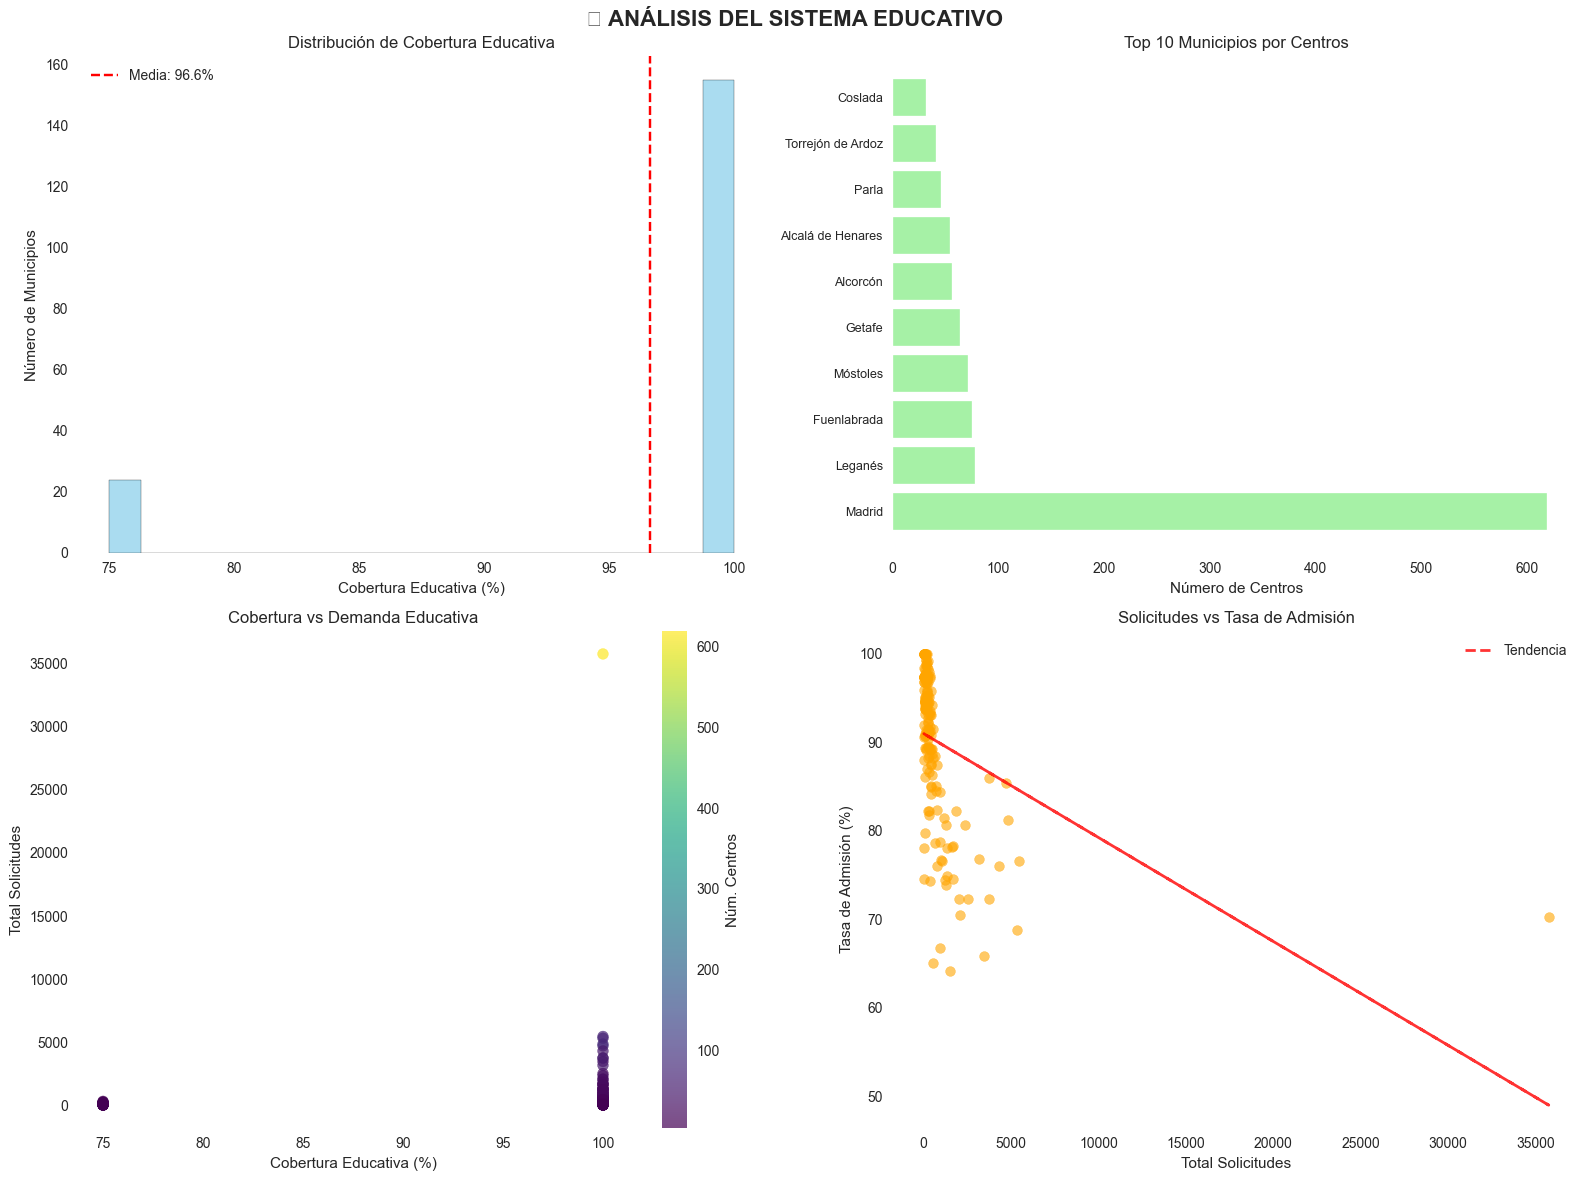

In [6]:
# === VISUALIZACIONES ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📚 ANÁLISIS DEL SISTEMA EDUCATIVO', fontsize=16, fontweight='bold')

# 1. Distribución de Cobertura
axes[0,0].hist(summary_df['cobertura_pct'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(summary_df['cobertura_pct'].mean(), color='red', linestyle='--',
                  label=f'Media: {summary_df["cobertura_pct"].mean():.1f}%')
axes[0,0].set_xlabel('Cobertura Educativa (%)')
axes[0,0].set_ylabel('Número de Municipios')
axes[0,0].set_title('Distribución de Cobertura Educativa')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Top 10 Municipios por Centros
top_centers = summary_df.nlargest(10, 'centros')
y_pos = range(len(top_centers))
bars = axes[0,1].barh(y_pos, top_centers['centros'], color='lightgreen', alpha=0.8)
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name
                           for name in top_centers['municipio']], fontsize=9)
axes[0,1].set_xlabel('Número de Centros')
axes[0,1].set_title('Top 10 Municipios por Centros')
axes[0,1].grid(True, alpha=0.3, axis='x')

# 3. Cobertura vs Demanda
scatter = axes[1,0].scatter(summary_df['cobertura_pct'], summary_df['solicitudes'],
                           c=summary_df['centros'], cmap='viridis', alpha=0.7, s=60)
axes[1,0].set_xlabel('Cobertura Educativa (%)')
axes[1,0].set_ylabel('Total Solicitudes')
axes[1,0].set_title('Cobertura vs Demanda Educativa')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='Núm. Centros')

# 4. Tasa de Admisión vs Solicitudes
axes[1,1].scatter(summary_df['solicitudes'], summary_df['tasa_admision'],
                  alpha=0.6, color='orange', s=50)
axes[1,1].set_xlabel('Total Solicitudes')
axes[1,1].set_ylabel('Tasa de Admisión (%)')
axes[1,1].set_title('Solicitudes vs Tasa de Admisión')
axes[1,1].grid(True, alpha=0.3)

# Añadir línea de tendencia
if len(summary_df) > 1:
    z = np.polyfit(summary_df['solicitudes'], summary_df['tasa_admision'], 1)
    p = np.poly1d(z)
    axes[1,1].plot(summary_df['solicitudes'], p(summary_df['solicitudes']),
                   "r--", alpha=0.8, linewidth=2, label='Tendencia')
    axes[1,1].legend()

plt.tight_layout()
plt.show()


In [7]:
# === ANÁLISIS POR PROBLEMÁTICAS ===
print("🚨 MUNICIPIOS CON PROBLEMÁTICAS")
print("="*50)

# Municipios sin cobertura
sin_cobertura = summary_df[summary_df['cobertura_pct'] == 0]
if not sin_cobertura.empty:
    print(f"\n❌ SIN COBERTURA EDUCATIVA ({len(sin_cobertura)} municipios):")
    display(sin_cobertura[['municipio', 'centros']].head(10))

# Municipios con baja tasa de admisión (< 70%)
baja_admision = summary_df[
    (summary_df['tasa_admision'] < 70) &
    (summary_df['solicitudes'] > 0)
].sort_values('tasa_admision')

if not baja_admision.empty:
    print(f"\n⚠️ BAJA TASA DE ADMISIÓN ({len(baja_admision)} municipios):")
    display(baja_admision[['municipio', 'solicitudes', 'admitidas', 'tasa_admision']].head(10))

# Municipios con alta demanda y baja cobertura
alta_demanda_baja_cobertura = summary_df[
    (summary_df['solicitudes'] > summary_df['solicitudes'].quantile(0.75)) &
    (summary_df['cobertura_pct'] < 75)
].sort_values('solicitudes', ascending=False)

if not alta_demanda_baja_cobertura.empty:
    print(f"\n🔥 ALTA DEMANDA + BAJA COBERTURA ({len(alta_demanda_baja_cobertura)} municipios):")
    display(alta_demanda_baja_cobertura[['municipio', 'cobertura_pct', 'solicitudes', 'centros']])

print("\n✅ ANÁLISIS COMPLETADO")


🚨 MUNICIPIOS CON PROBLEMÁTICAS

⚠️ BAJA TASA DE ADMISIÓN (5 municipios):


,municipio,solicitudes,admitidas,tasa_admision
169,Majadahonda,1525,978,64.131148
26,Villanueva de la Cañada,542,353,65.129151
174,Rivas-Vaciamadrid,3488,2296,65.825688
161,Boadilla del Monte,949,634,66.807165
166,Getafe,5326,3663,68.775817



✅ ANÁLISIS COMPLETADO


In [8]:
# === ANÁLISIS POR CICLOS EDUCATIVOS ===
def analyze_by_cycle(data):
    """Análisis detallado por ciclo educativo"""
    target_year = "2022-2023"  # Año específico para el análisis

    cycle_summary = []
    cycles = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']

    for cycle in cycles:
        cycle_admissions = data['admissions'][
            (data['admissions']['year'] == target_year) &
            (data['admissions']['cycle'] == cycle)
        ]

        cycle_enrollment = data['enrollment'][
            (data['enrollment']['year'] == target_year) &
            (data['enrollment']['cycle'] == cycle)
        ]

        total_presented = cycle_admissions[cycle_admissions['type_solicitude'] == 'Presentadas']['total'].sum()
        total_admitted = cycle_admissions[cycle_admissions['type_solicitude'] == 'Admitidas']['total'].sum()
        total_enrolled = cycle_enrollment['total'].sum()

        cycle_summary.append({
            'ciclo': cycle.replace('_', ' ').title(),
            'centros_ofertantes': cycle_admissions['id_education'].nunique(),
            'solicitudes': total_presented,
            'admitidas': total_admitted,
            'matriculados': total_enrolled,
            'tasa_admision': (total_admitted / total_presented * 100) if total_presented > 0 else 0,
            'utilizacion': (total_enrolled / total_admitted * 100) if total_admitted > 0 else 0
        })

    return pd.DataFrame(cycle_summary)

cycle_df = analyze_by_cycle(data)
print("📚 ANÁLISIS POR CICLOS EDUCATIVOS")
print("="*50)
display(cycle_df.round(1))


📚 ANÁLISIS POR CICLOS EDUCATIVOS


,ciclo,centros_ofertantes,solicitudes,admitidas,matriculados,tasa_admision,utilizacion
0,Infantil I Ciclo,381,41750,30406,31332,72.8,103.0
1,Infantil Ii Ciclo,824,30363,26641,94437,87.7,354.5
2,Primaria,806,8758,3712,229423,42.4,6180.6
3,Eso,343,42184,33375,161467,79.1,483.8


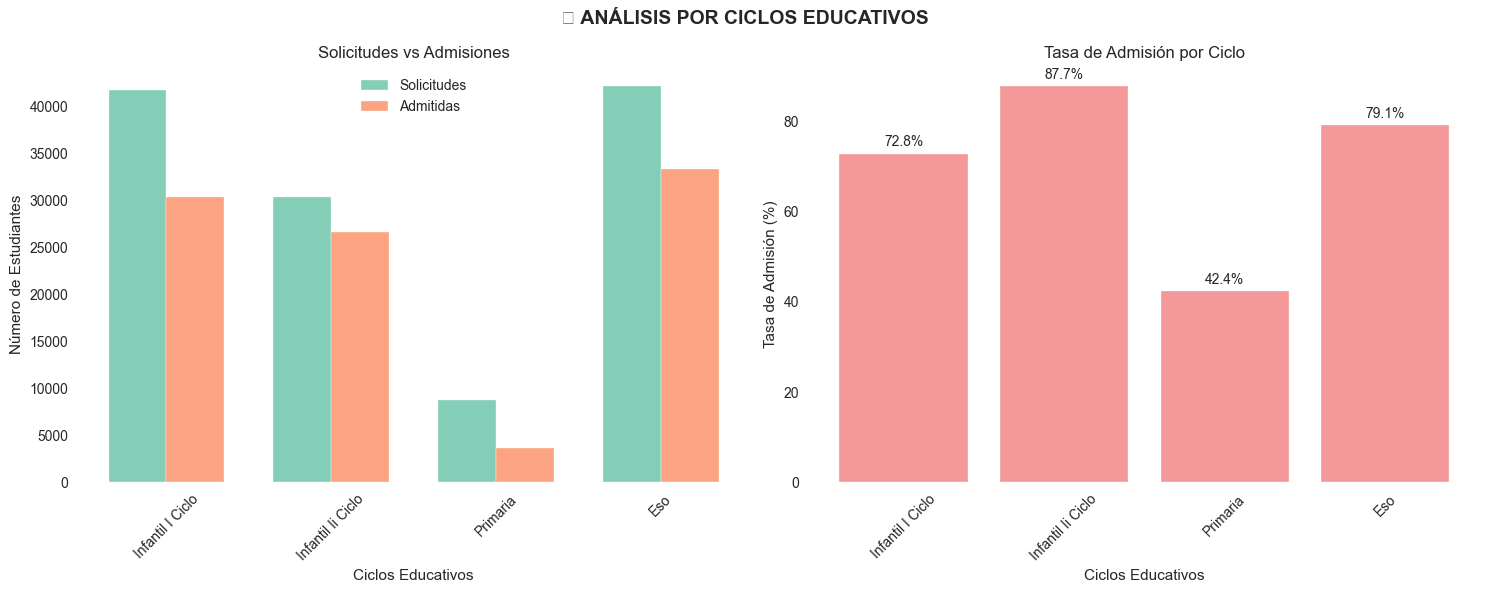

In [9]:
# === GRÁFICO DE CICLOS ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('📊 ANÁLISIS POR CICLOS EDUCATIVOS', fontsize=14, fontweight='bold')

# Solicitudes vs Admitidas por ciclo
x = range(len(cycle_df))
width = 0.35

ax1.bar([i - width/2 for i in x], cycle_df['solicitudes'], width, label='Solicitudes', alpha=0.8)
ax1.bar([i + width/2 for i in x], cycle_df['admitidas'], width, label='Admitidas', alpha=0.8)
ax1.set_xlabel('Ciclos Educativos')
ax1.set_ylabel('Número de Estudiantes')
ax1.set_title('Solicitudes vs Admisiones')
ax1.set_xticks(x)
ax1.set_xticklabels(cycle_df['ciclo'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Tasa de admisión por ciclo
bars = ax2.bar(cycle_df['ciclo'], cycle_df['tasa_admision'], color='lightcoral', alpha=0.8)
ax2.set_xlabel('Ciclos Educativos')
ax2.set_ylabel('Tasa de Admisión (%)')
ax2.set_title('Tasa de Admisión por Ciclo')
ax2.set_xticklabels(cycle_df['ciclo'], rotation=45)
ax2.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [10]:
# === RANKING MUNICIPAL INTERACTIVO ===
def create_municipal_ranking(summary_df):
    """Crea ranking detallado de municipios"""

    # Calcular score compuesto
    summary_df = summary_df.copy()
    summary_df['score_cobertura'] = summary_df['cobertura_pct'] / 100
    summary_df['score_admision'] = summary_df['tasa_admision'] / 100
    summary_df['score_demanda'] = np.where(summary_df['solicitudes'] > 0, 1, 0)

    # Score final (ponderado)
    summary_df['score_final'] = (
        summary_df['score_cobertura'] * 0.4 +
        summary_df['score_admision'] * 0.3 +
        summary_df['score_demanda'] * 0.3
    ) * 100

    return summary_df.sort_values('score_final', ascending=False)

ranking_df = create_municipal_ranking(summary_df)

print("🏆 RANKING MUNICIPAL EDUCATIVO")
print("="*50)
print("Score basado en: Cobertura (40%) + Tasa Admisión (30%) + Demanda (30%)")

top_15 = ranking_df.head(15)[['municipio', 'cobertura_pct', 'tasa_admision', 'solicitudes', 'score_final']]
top_15.columns = ['Municipio', 'Cobertura %', 'Tasa Admisión %', 'Solicitudes', 'Score Final']
display(top_15.round(1))


🏆 RANKING MUNICIPAL EDUCATIVO
Score basado en: Cobertura (40%) + Tasa Admisión (30%) + Demanda (30%)


,Municipio,Cobertura %,Tasa Admisión %,Solicitudes,Score Final
46,Valdemaqueda,100.0,100.0,79,100.0
149,Cenicientos,100.0,100.0,30,100.0
63,Cadalso de los Vidrios,100.0,100.0,67,100.0
101,Collado Mediano,100.0,100.0,122,100.0
154,Navalagamella,100.0,100.0,167,100.0
128,Robledo de Chavela,100.0,100.0,117,100.0
119,Valdaracete,100.0,99.4,159,99.8
60,Villarejo de Salvanés,100.0,99.2,259,99.8
121,Fuentidueña de Tajo,100.0,99.0,192,99.7
41,Estremera,100.0,98.9,174,99.7


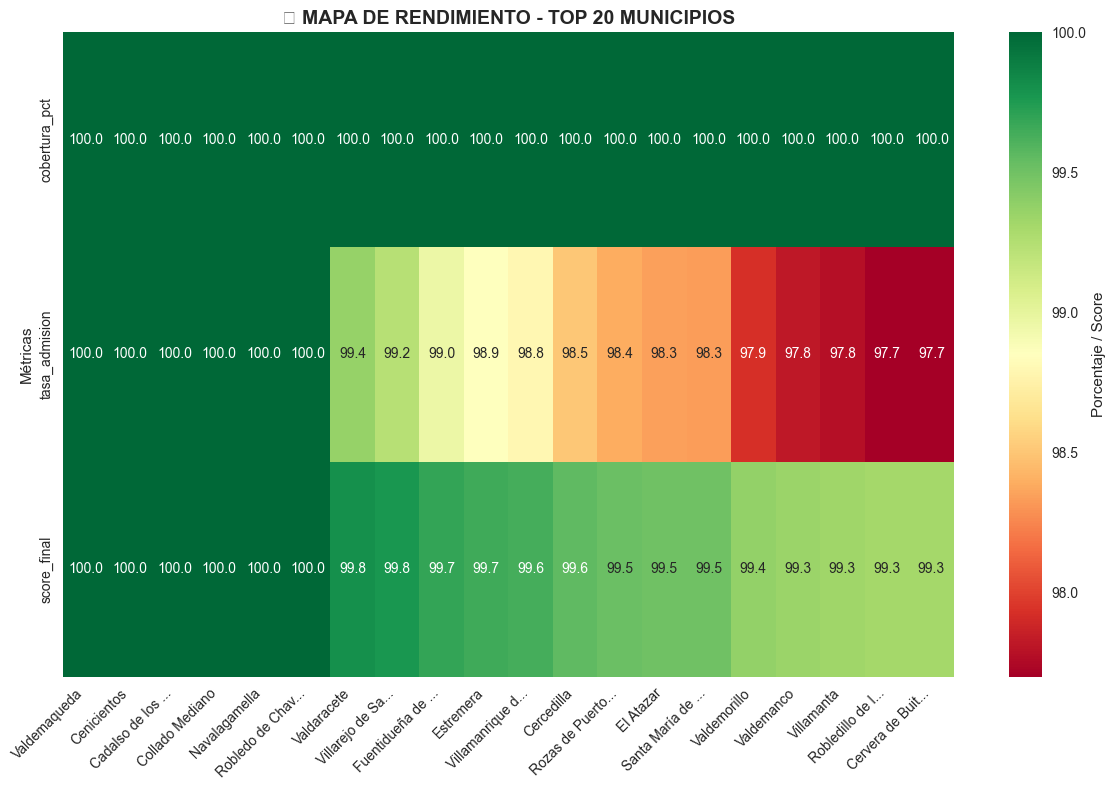

In [11]:
# === MAPA DE CALOR DE RENDIMIENTO ===
fig, ax = plt.subplots(figsize=(12, 8))

# Preparar datos para heatmap (top 20 municipios)
top_20 = ranking_df.head(20)
heatmap_data = top_20[['cobertura_pct', 'tasa_admision', 'score_final']].T
heatmap_data.columns = [name[:15] + '...' if len(name) > 15 else name
                       for name in top_20['municipio']]

# Crear heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn',
           cbar_kws={'label': 'Porcentaje / Score'}, ax=ax)
ax.set_title('🔥 MAPA DE RENDIMIENTO - TOP 20 MUNICIPIOS', fontsize=14, fontweight='bold')
ax.set_ylabel('Métricas')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:
# === ANÁLISIS DE EFICIENCIA ===
def efficiency_analysis(ranking_df):
    """Análisis de eficiencia: centros vs resultados"""

    # Eficiencia = (solicitudes atendidas / número de centros)
    efficiency_df = ranking_df.copy()
    efficiency_df['eficiencia_centros'] = np.where(
        efficiency_df['centros'] > 0,
        efficiency_df['solicitudes'] / efficiency_df['centros'],
        0
    )

    # Categorizar municipios
    efficiency_df['categoria'] = pd.cut(
        efficiency_df['eficiencia_centros'],
        bins=[0, 50, 150, 500, float('inf')],
        labels=['Baja Eficiencia', 'Eficiencia Media', 'Alta Eficiencia', 'Muy Alta Eficiencia']
    )

    return efficiency_df

efficiency_df = efficiency_analysis(ranking_df)

print("⚡ ANÁLISIS DE EFICIENCIA DE CENTROS")
print("="*50)

# Tabla de eficiencia
efficiency_summary = efficiency_df.groupby('categoria').agg({
    'municipio': 'count',
    'centros': 'sum',
    'solicitudes': 'sum',
    'eficiencia_centros': 'mean'
}).round(1)
efficiency_summary.columns = ['Municipios', 'Total Centros', 'Total Solicitudes', 'Eficiencia Promedio']
display(efficiency_summary)


⚡ ANÁLISIS DE EFICIENCIA DE CENTROS


,Municipios,Total Centros,Total Solicitudes,Eficiencia Promedio
categoria,,,,
Baja Eficiencia,140,1164,29989,23.9
Eficiencia Media,39,1616,108622,70.1
Alta Eficiencia,0,0,0,NaN
Muy Alta Eficiencia,0,0,0,NaN


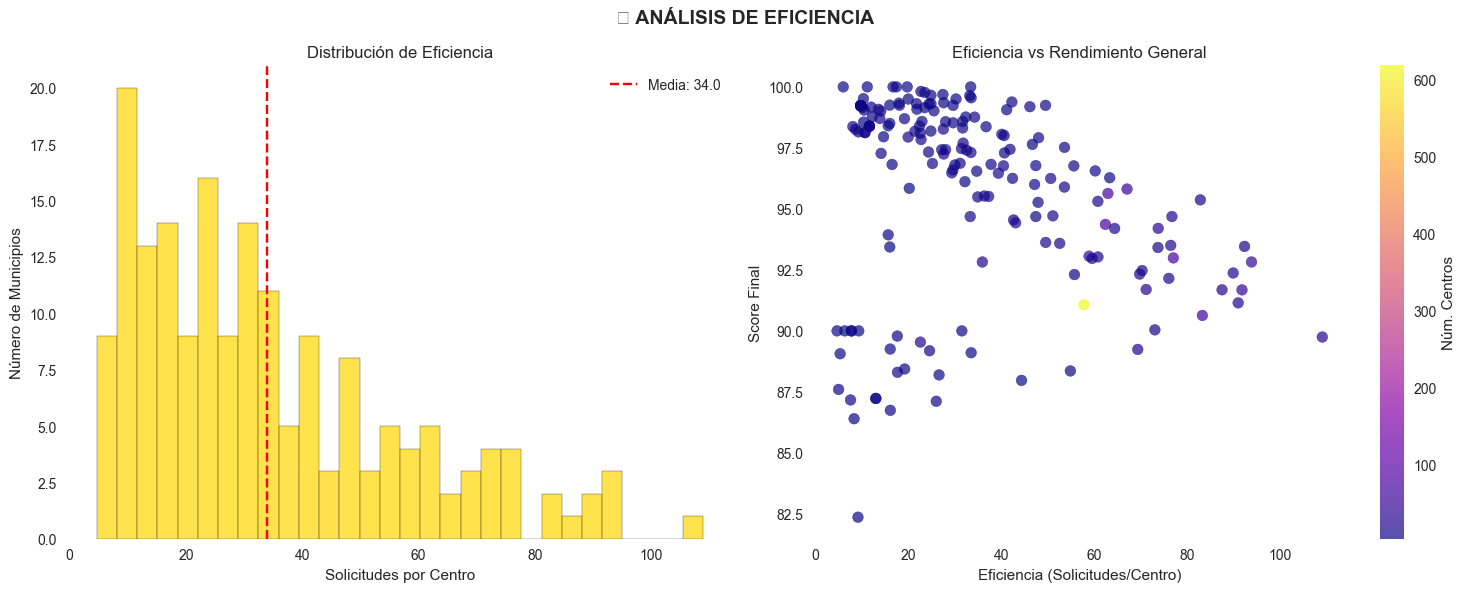

In [13]:
# === GRÁFICO DE EFICIENCIA ===
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('⚡ ANÁLISIS DE EFICIENCIA', fontsize=14, fontweight='bold')

# Distribución de eficiencia
ax1.hist(efficiency_df['eficiencia_centros'], bins=30, alpha=0.7, color='gold', edgecolor='black')
ax1.axvline(efficiency_df['eficiencia_centros'].mean(), color='red', linestyle='--',
           label=f'Media: {efficiency_df["eficiencia_centros"].mean():.1f}')
ax1.set_xlabel('Solicitudes por Centro')
ax1.set_ylabel('Número de Municipios')
ax1.set_title('Distribución de Eficiencia')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Eficiencia vs Score Final
scatter = ax2.scatter(efficiency_df['eficiencia_centros'], efficiency_df['score_final'],
                     c=efficiency_df['centros'], cmap='plasma', alpha=0.7, s=60)
ax2.set_xlabel('Eficiencia (Solicitudes/Centro)')
ax2.set_ylabel('Score Final')
ax2.set_title('Eficiencia vs Rendimiento General')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Núm. Centros')

plt.tight_layout()
plt.show()


In [14]:
# === RESUMEN EJECUTIVO ===
def executive_summary(ranking_df, cycle_df, efficiency_df):
    """Genera resumen ejecutivo con KPIs principales"""

    total_municipios = len(ranking_df)
    municipios_sin_cobertura = (ranking_df['cobertura_pct'] == 0).sum()
    municipios_cobertura_completa = (ranking_df['cobertura_pct'] == 100).sum()

    mejor_municipio = ranking_df.loc[ranking_df['score_final'].idxmax()]
    peor_municipio = ranking_df.loc[ranking_df['score_final'].idxmin()]

    ciclo_mas_demandado = cycle_df.loc[cycle_df['solicitudes'].idxmax()]
    ciclo_mejor_admision = cycle_df.loc[cycle_df['tasa_admision'].idxmax()]

    print("📋 RESUMEN EJECUTIVO")
    print("="*60)
    print(f"🏛️  COBERTURA TERRITORIAL:")
    print(f"   • Total municipios analizados: {total_municipios}")
    print(f"   • Sin cobertura educativa: {municipios_sin_cobertura} ({municipios_sin_cobertura/total_municipios*100:.1f}%)")
    print(f"   • Cobertura completa: {municipios_cobertura_completa} ({municipios_cobertura_completa/total_municipios*100:.1f}%)")
    print(f"   • Cobertura promedio: {ranking_df['cobertura_pct'].mean():.1f}%")

    print(f"\n🎯 RENDIMIENTO:")
    print(f"   • Mejor municipio: {mejor_municipio['municipio']} (Score: {mejor_municipio['score_final']:.1f})")
    print(f"   • Municipio con mayor desafío: {peor_municipio['municipio']} (Score: {peor_municipio['score_final']:.1f})")
    print(f"   • Tasa admisión promedio: {ranking_df['tasa_admision'].mean():.1f}%")

    print(f"\n📚 CICLOS EDUCATIVOS:")
    print(f"   • Mayor demanda: {ciclo_mas_demandado['ciclo']} ({ciclo_mas_demandado['solicitudes']:,.0f} solicitudes)")
    print(f"   • Mejor tasa admisión: {ciclo_mejor_admision['ciclo']} ({ciclo_mejor_admision['tasa_admision']:.1f}%)")

    print(f"\n⚡ EFICIENCIA:")
    print(f"   • Promedio solicitudes/centro: {efficiency_df['eficiencia_centros'].mean():.1f}")
    print(f"   • Municipios alta eficiencia: {(efficiency_df['categoria'] == 'Alta Eficiencia').sum()}")

    return {
        'total_municipios': total_municipios,
        'sin_cobertura': municipios_sin_cobertura,
        'cobertura_completa': municipios_cobertura_completa,
        'mejor_municipio': mejor_municipio['municipio'],
        'ciclo_mayor_demanda': ciclo_mas_demandado['ciclo']
    }

kpis = executive_summary(ranking_df, cycle_df, efficiency_df)

print("\n✅ ANÁLISIS EDUCATIVO COMPLETADO")
print("="*60)


📋 RESUMEN EJECUTIVO
🏛️  COBERTURA TERRITORIAL:
   • Total municipios analizados: 179
   • Sin cobertura educativa: 0 (0.0%)
   • Cobertura completa: 155 (86.6%)
   • Cobertura promedio: 96.6%

🎯 RENDIMIENTO:
   • Mejor municipio: Valdemaqueda (Score: 100.0)
   • Municipio con mayor desafío: Villar del Olmo (Score: 82.4)
   • Tasa admisión promedio: 90.1%

📚 CICLOS EDUCATIVOS:
   • Mayor demanda: Eso (42,184 solicitudes)
   • Mejor tasa admisión: Infantil Ii Ciclo (87.7%)

⚡ EFICIENCIA:
   • Promedio solicitudes/centro: 34.0
   • Municipios alta eficiencia: 0

✅ ANÁLISIS EDUCATIVO COMPLETADO


In [15]:
# === ANÁLISIS DE ACCESIBILIDAD POR CICLO EDUCATIVO ===
def analyze_accessibility_by_cycle(data):
    """Analiza la accesibilidad por ciclo educativo por municipio"""

    # Mapeo centro-municipio con nombres
    center_map = data['edu_municipality'].merge(
        data['municipality'][['id', 'name']].rename(columns={'id': 'id_municipality', 'name': 'municipality_name'}),
        on='id_municipality'
    )

    cycles = ['infantil_i_ciclo', 'infantil_ii_ciclo', 'primaria', 'eso']
    target_year = "2022-2023"  # Año específico para el análisis

    # Filtrar datos por año específico 2022-2023
    admissions = data['admissions'][data['admissions']['year'] == target_year]
    enrollment = data['enrollment'][data['enrollment']['year'] == target_year]

    accessibility_list = []

    for muni_id in center_map['id_municipality'].unique():
        muni_data = center_map[center_map['id_municipality'] == muni_id]
        muni_name = muni_data['municipality_name'].iloc[0]
        centers = muni_data['id_education'].tolist()

        muni_row = {'municipio': muni_name, 'total_centros': len(centers)}

        # Analizar cada ciclo
        for cycle in cycles:
            # Centros que ofrecen este ciclo
            cycle_centers_adm = admissions[
                (admissions['id_education'].isin(centers)) &
                (admissions['cycle'] == cycle)
            ]['id_education'].nunique()

            cycle_centers_enr = enrollment[
                (enrollment['id_education'].isin(centers)) &
                (enrollment['cycle'] == cycle)
            ]['id_education'].nunique()

            cycle_centers = max(cycle_centers_adm, cycle_centers_enr)

            # Solicitudes, admisiones y matrículas para este ciclo
            cycle_admissions = admissions[
                (admissions['id_education'].isin(centers)) &
                (admissions['cycle'] == cycle)
            ]

            cycle_enrollment_data = enrollment[
                (enrollment['id_education'].isin(centers)) &
                (enrollment['cycle'] == cycle)
            ]

            cycle_solicitudes = cycle_admissions[cycle_admissions['type_solicitude'] == 'Presentadas']['total'].sum()
            cycle_admitidas = cycle_admissions[cycle_admissions['type_solicitude'] == 'Admitidas']['total'].sum()
            cycle_matriculados = cycle_enrollment_data['total'].sum()

            # Métricas del ciclo
            cycle_clean = cycle.replace('_', ' ').replace('ciclo', '').strip()
            muni_row[f'{cycle_clean}_centros'] = cycle_centers
            muni_row[f'{cycle_clean}_disponible'] = 1 if cycle_centers > 0 else 0
            muni_row[f'{cycle_clean}_solicitudes'] = cycle_solicitudes
            muni_row[f'{cycle_clean}_admitidas'] = cycle_admitidas
            muni_row[f'{cycle_clean}_matriculados'] = cycle_matriculados
            muni_row[f'{cycle_clean}_tasa_admision'] = (cycle_admitidas / cycle_solicitudes * 100) if cycle_solicitudes > 0 else 0
            muni_row[f'{cycle_clean}_tasa_utilizacion'] = (cycle_matriculados / cycle_admitidas * 100) if cycle_admitidas > 0 else 0

        # Calcular métricas de accesibilidad
        ciclos_disponibles = sum([muni_row[f'{cycle.replace("_", " ").replace("ciclo", "").strip()}_disponible'] for cycle in cycles])
        muni_row['ciclos_disponibles'] = ciclos_disponibles
        muni_row['accesibilidad_pct'] = (ciclos_disponibles / len(cycles)) * 100
        muni_row['cobertura_completa'] = 1 if ciclos_disponibles == len(cycles) else 0

        # Totales agregados por municipio
        muni_row['total_solicitudes'] = sum([muni_row[f'{cycle.replace("_", " ").replace("ciclo", "").strip()}_solicitudes'] for cycle in cycles])
        muni_row['total_admitidas'] = sum([muni_row[f'{cycle.replace("_", " ").replace("ciclo", "").strip()}_admitidas'] for cycle in cycles])
        muni_row['total_matriculados'] = sum([muni_row[f'{cycle.replace("_", " ").replace("ciclo", "").strip()}_matriculados'] for cycle in cycles])

        accessibility_list.append(muni_row)

    return pd.DataFrame(accessibility_list).sort_values('accesibilidad_pct', ascending=False)

accessibility_df = analyze_accessibility_by_cycle(data)

print("🎯 ACCESIBILIDAD EDUCATIVA POR CICLO Y MUNICIPIO")
print("="*60)

# Mostrar estadísticas generales de accesibilidad
access_stats = pd.DataFrame({
    'Métrica': [
        'Municipios con Acceso Completo (4 ciclos)',
        'Municipios con Acceso Parcial (1-3 ciclos)',
        'Municipios sin Acceso Educativo',
        'Accesibilidad Promedio (%)',
        'Municipios con Infantil I',
        'Municipios con Infantil II',
        'Municipios con Primaria',
        'Municipios con ESO'
    ],
    'Valor': [
        (accessibility_df['accesibilidad_pct'] == 100).sum(),
        ((accessibility_df['accesibilidad_pct'] > 0) & (accessibility_df['accesibilidad_pct'] < 100)).sum(),
        (accessibility_df['accesibilidad_pct'] == 0).sum(),
        accessibility_df['accesibilidad_pct'].mean(),
        accessibility_df['infantil i_disponible'].sum(),
        accessibility_df['infantil ii_disponible'].sum(),
        accessibility_df['primaria_disponible'].sum(),
        accessibility_df['eso_disponible'].sum()
    ]
})

display(access_stats.round(1))


🎯 ACCESIBILIDAD EDUCATIVA POR CICLO Y MUNICIPIO


,Métrica,Valor
0,Municipios con Acceso Completo (4 ciclos),155.0
1,Municipios con Acceso Parcial (1-3 ciclos),24.0
2,Municipios sin Acceso Educativo,0.0
3,Accesibilidad Promedio (%),96.6
4,Municipios con Infantil I,155.0
5,Municipios con Infantil II,179.0
6,Municipios con Primaria,179.0
7,Municipios con ESO,179.0


In [16]:
# === TABLA DETALLADA DE ACCESIBILIDAD ===
print("\n📊 DETALLE DE ACCESIBILIDAD POR MUNICIPIO (Top 15)")
print("="*70)

# Seleccionar columnas para mostrar - ahora con más detalle
display_cols = ['municipio', 'accesibilidad_pct', 'total_solicitudes', 'total_admitidas', 'total_matriculados', 'total_centros']
top_accessibility = accessibility_df.head(15)[display_cols].copy()
top_accessibility.columns = ['Municipio', 'Accesibilidad %', 'Solicitudes', 'Admitidas', 'Matriculados', 'Total Centros']
display(top_accessibility)



📊 DETALLE DE ACCESIBILIDAD POR MUNICIPIO (Top 15)


,Municipio,Accesibilidad %,Solicitudes,Admitidas,Matriculados,Total Centros
0,Zarzalejo,100.0,158,148,966,7
121,Fuentidueña de Tajo,100.0,192,190,798,7
111,Torrejón de la Calzada,100.0,482,416,1621,9
112,La Acebeda,100.0,63,61,329,6
113,Alameda del Valle,100.0,96,90,742,9
114,Ambite,100.0,101,87,862,5
117,Bustarviejo,100.0,285,269,1849,9
118,Batres,100.0,375,344,851,7
119,Valdaracete,100.0,159,158,808,7
120,Casarrubuelos,100.0,401,375,1467,10


In [17]:
# === TABLA DETALLADA POR CICLOS ===
print("\n📚 DETALLE POR CICLOS EDUCATIVOS (Top 10)")
print("="*80)

# Crear tabla con métricas por ciclo
cycle_detail_cols = ['municipio',
                    'infantil i_solicitudes', 'infantil i_admitidas', 'infantil i_matriculados',
                    'infantil ii_solicitudes', 'infantil ii_admitidas', 'infantil ii_matriculados',
                    'primaria_solicitudes', 'primaria_admitidas', 'primaria_matriculados',
                    'eso_solicitudes', 'eso_admitidas', 'eso_matriculados']

cycle_detail = accessibility_df.head(10)[cycle_detail_cols].copy()
cycle_detail.columns = ['Municipio',
                       'Inf.I Sol.', 'Inf.I Adm.', 'Inf.I Mat.',
                       'Inf.II Sol.', 'Inf.II Adm.', 'Inf.II Mat.',
                       'Prim. Sol.', 'Prim. Adm.', 'Prim. Mat.',
                       'ESO Sol.', 'ESO Adm.', 'ESO Mat.']
display(cycle_detail)



📚 DETALLE POR CICLOS EDUCATIVOS (Top 10)


,Municipio,Inf.I Sol.,Inf.I Adm.,Inf.I Mat.,Inf.II Sol.,Inf.II Adm.,Inf.II Mat.,Prim. Sol.,Prim. Adm.,Prim. Mat.,ESO Sol.,ESO Adm.,ESO Mat.
0,Zarzalejo,10,9,8,24,23,75,5,5,358,119,111,525
121,Fuentidueña de Tajo,37,35,35,13,13,53,8,8,122,134,134,588
111,Torrejón de la Calzada,255,209,198,82,80,273,21,15,584,124,112,566
112,La Acebeda,38,37,32,22,22,85,2,2,181,1,0,31
113,Alameda del Valle,31,28,27,45,45,133,8,5,384,12,12,198
114,Ambite,10,10,10,64,62,199,18,12,461,9,3,192
117,Bustarviejo,27,25,23,80,79,223,10,7,550,168,158,1053
118,Batres,225,211,201,8,8,23,4,4,33,138,121,594
119,Valdaracete,12,11,11,10,10,62,3,3,147,134,134,588
120,Casarrubuelos,92,91,82,25,25,96,5,5,210,279,254,1079


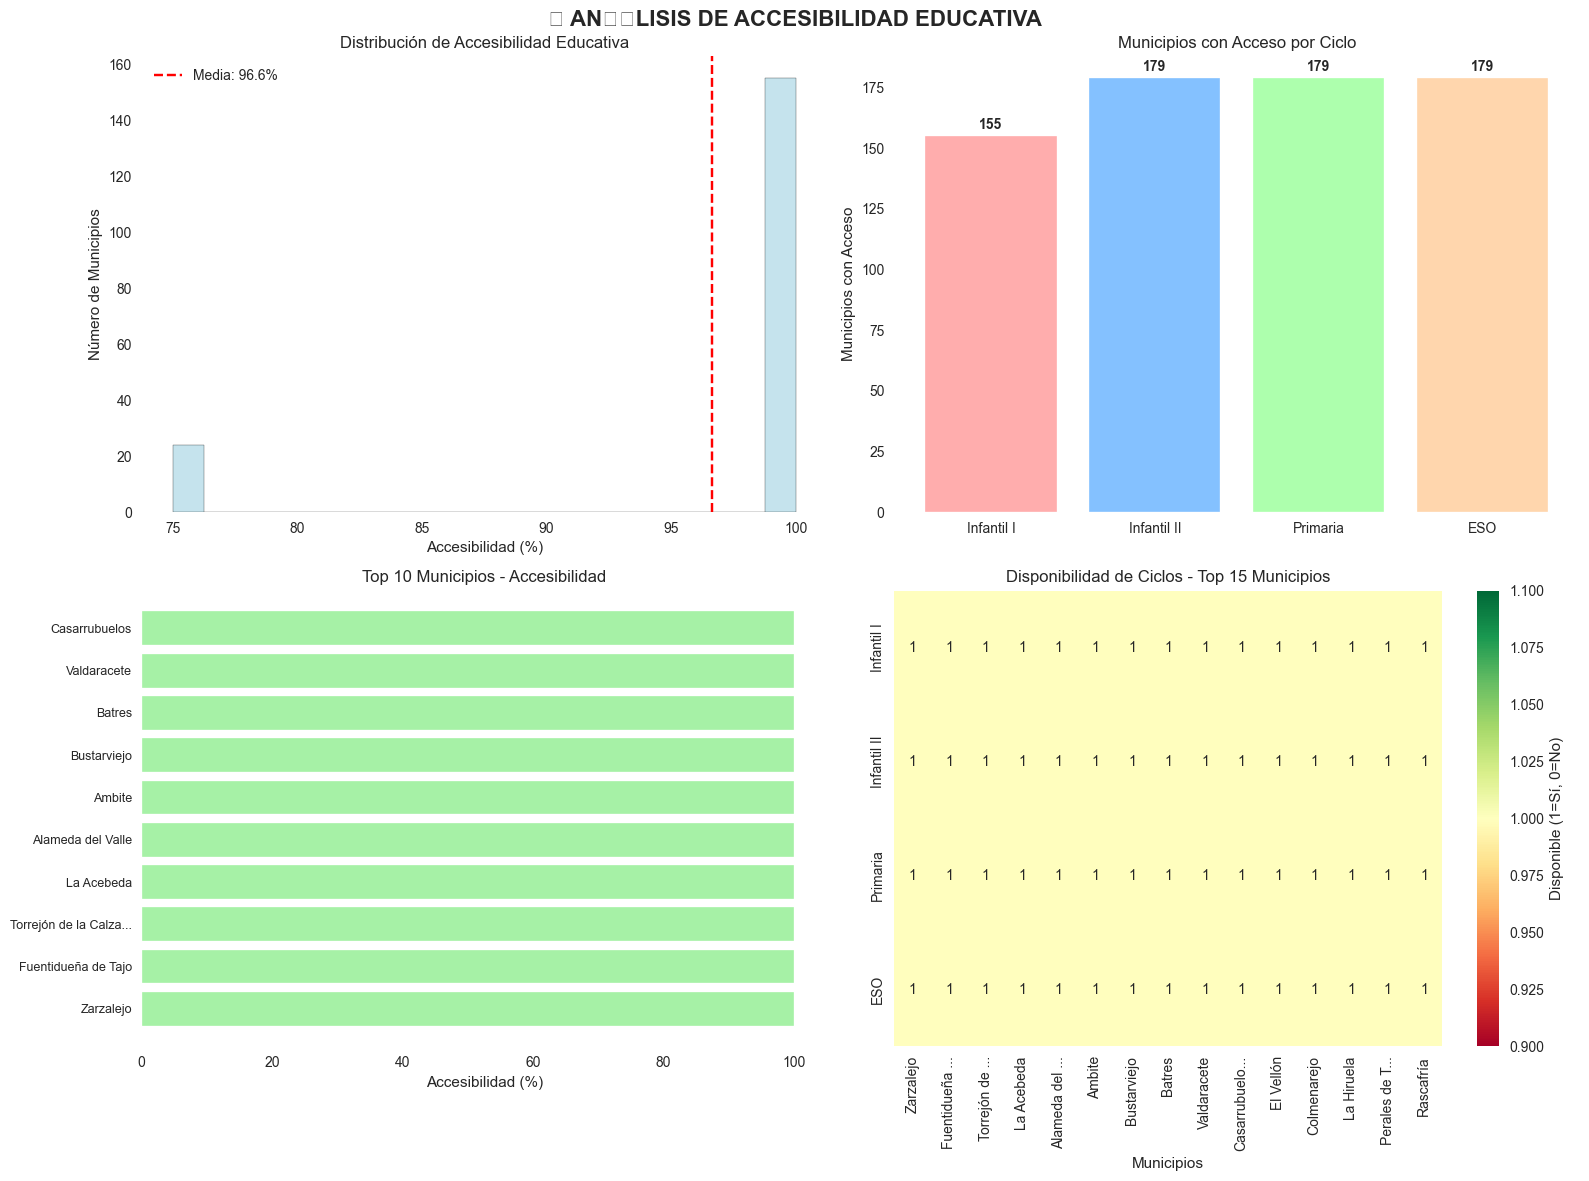

In [18]:
# === VISUALIZACIÓN DE ACCESIBILIDAD ===
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎯 AN��LISIS DE ACCESIBILIDAD EDUCATIVA', fontsize=16, fontweight='bold')

# 1. Distribución de Accesibilidad
ax1.hist(accessibility_df['accesibilidad_pct'], bins=20, alpha=0.7, color='lightblue', edgecolor='black')
ax1.axvline(accessibility_df['accesibilidad_pct'].mean(), color='red', linestyle='--',
           label=f'Media: {accessibility_df["accesibilidad_pct"].mean():.1f}%')
ax1.set_xlabel('Accesibilidad (%)')
ax1.set_ylabel('Número de Municipios')
ax1.set_title('Distribución de Accesibilidad Educativa')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Disponibilidad por Ciclo
cycles_availability = {
    'Infantil I': accessibility_df['infantil i_disponible'].sum(),
    'Infantil II': accessibility_df['infantil ii_disponible'].sum(),
    'Primaria': accessibility_df['primaria_disponible'].sum(),
    'ESO': accessibility_df['eso_disponible'].sum()
}

bars = ax2.bar(cycles_availability.keys(), cycles_availability.values(),
               color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'], alpha=0.8)
ax2.set_ylabel('Municipios con Acceso')
ax2.set_title('Municipios con Acceso por Ciclo')
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontweight='bold')

# 3. Top 10 Municipios por Accesibilidad
top_10_access = accessibility_df.head(10)
y_pos = range(len(top_10_access))
bars3 = ax3.barh(y_pos, top_10_access['accesibilidad_pct'], color='lightgreen', alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels([name[:20] + '...' if len(name) > 20 else name
                    for name in top_10_access['municipio']], fontsize=9)
ax3.set_xlabel('Accesibilidad (%)')
ax3.set_title('Top 10 Municipios - Accesibilidad')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Mapa de Calor de Ciclos por Municipio (Top 15)
heatmap_data = accessibility_df.head(15)[['infantil i_disponible', 'infantil ii_disponible',
                                         'primaria_disponible', 'eso_disponible']].T
heatmap_data.columns = [name[:12] + '...' if len(name) > 12 else name
                       for name in accessibility_df.head(15)['municipio']]
heatmap_data.index = ['Infantil I', 'Infantil II', 'Primaria', 'ESO']

sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', cbar_kws={'label': 'Disponible (1=Sí, 0=No)'},
           ax=ax4, fmt='d')
ax4.set_title('Disponibilidad de Ciclos - Top 15 Municipios')
ax4.set_xlabel('Municipios')

plt.tight_layout()
plt.show()


In [19]:
# === ANÁLISIS DE BRECHAS DE ACCESIBILIDAD ===
print("🚨 BRECHAS DE ACCESIBILIDAD EDUCATIVA")
print("="*50)

# Municipios sin acceso completo
sin_acceso_completo = accessibility_df[accessibility_df['accesibilidad_pct'] < 100].copy()

if not sin_acceso_completo.empty:
    print(f"\n⚠️ MUNICIPIOS SIN ACCESO COMPLETO ({len(sin_acceso_completo)} municipios):")

    # Identificar qué ciclos faltan más frecuentemente
    ciclos_faltantes = {}
    for _, row in sin_acceso_completo.iterrows():
        if row['infantil i_disponible'] == 0:
            ciclos_faltantes['Infantil I'] = ciclos_faltantes.get('Infantil I', 0) + 1
        if row['infantil ii_disponible'] == 0:
            ciclos_faltantes['Infantil II'] = ciclos_faltantes.get('Infantil II', 0) + 1
        if row['primaria_disponible'] == 0:
            ciclos_faltantes['Primaria'] = ciclos_faltantes.get('Primaria', 0) + 1
        if row['eso_disponible'] == 0:
            ciclos_faltantes['ESO'] = ciclos_faltantes.get('ESO', 0) + 1

    print("\n📊 CICLOS MÁS FALTANTES:")
    for ciclo, count in sorted(ciclos_faltantes.items(), key=lambda x: x[1], reverse=True):
        print(f"   • {ciclo}: {count} municipios sin acceso")

    # Mostrar los 10 municipios con menor accesibilidad
    print(f"\n❌ MUNICIPIOS CON MENOR ACCESIBILIDAD:")
    bottom_10 = sin_acceso_completo.tail(10)[['municipio', 'accesibilidad_pct', 'ciclos_disponibles', 'total_centros']]
    bottom_10.columns = ['Municipio', 'Accesibilidad %', 'Ciclos Disponibles', 'Total Centros']
    display(bottom_10)

# Municipios con alta demanda pero baja accesibilidad
alta_demanda_baja_acceso = accessibility_df[
    (accessibility_df['infantil i_solicitudes'] + accessibility_df['infantil ii_solicitudes'] +
     accessibility_df['primaria_solicitudes'] + accessibility_df['eso_solicitudes'] >
     accessibility_df['infantil i_solicitudes'].quantile(0.75)) &
    (accessibility_df['accesibilidad_pct'] < 75)
].sort_values('accesibilidad_pct')

if not alta_demanda_baja_acceso.empty:
    print(f"\n🔥 ALTA DEMANDA + BAJA ACCESIBILIDAD ({len(alta_demanda_baja_acceso)} municipios):")
    demanda_cols = ['municipio', 'accesibilidad_pct', 'ciclos_disponibles', 'total_centros']
    display(alta_demanda_baja_acceso[demanda_cols].head(10))

print("\n✅ ANÁLISIS DE ACCESIBILIDAD COMPLETADO")


🚨 BRECHAS DE ACCESIBILIDAD EDUCATIVA

⚠️ MUNICIPIOS SIN ACCESO COMPLETO (24 municipios):

📊 CICLOS MÁS FALTANTES:
   • Infantil I: 24 municipios sin acceso

❌ MUNICIPIOS CON MENOR ACCESIBILIDAD:


,Municipio,Accesibilidad %,Ciclos Disponibles,Total Centros
38,Morata de Tajuña,75.0,3,8
69,Villaconejos,75.0,3,6
116,Fresnedillas de la Oliva,75.0,3,6
141,Redueña,75.0,3,5
124,Villamantilla,75.0,3,6
115,Navalafuente,75.0,3,9
28,Venturada,75.0,3,6
150,Pelayos de la Presa,75.0,3,5
64,El Berrueco,75.0,3,10
45,Valdilecha,75.0,3,6



✅ ANÁLISIS DE ACCESIBILIDAD COMPLETADO


In [20]:
# === ANÁLISIS DEMOGRÁFICO Y CAPACIDAD EDUCATIVA ===
def load_demographics_data():
    """Carga datos demográficos por municipio y rango de edad"""
    demographics = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv')

    # Filtrar por año 2024 y excluir 'total' y rangos no estándar
    demographics_2024 = demographics[
        (demographics['year'] == 2024) &
        (demographics['range'] != 'total') &
        (~demographics['range'].str.contains('n', na=False))
    ].copy()

    return demographics_2024

def analyze_educational_capacity(accessibility_df, demographics_df):
    """Analiza la capacidad educativa vs demanda demográfica por municipio"""

    # Mapeo de ciclos educativos a rangos de edad
    cycle_age_mapping = {
        'infantil i': '0-4',      # Infantil I Ciclo: 0-4 años
        'infantil ii': '5-9',     # Infantil II Ciclo: 5-9 años
        'primaria': '10-14',      # Primaria: 10-14 años
        'eso': '15-19'            # ESO: 15-19 años
    }

    # Preparar datos demográficos por municipio
    demo_pivot = demographics_df.pivot_table(
        index=['id_secondary_municipality', 'name'],
        columns='range',
        values='total',
        fill_value=0
    ).reset_index()

    # Normalizar nombres para hacer coincidencias
    demo_pivot['name_normalized'] = demo_pivot['name'].str.lower().str.strip()
    # Crear copia para evitar modificar el DataFrame original
    accessibility_copy = accessibility_df.copy()
    accessibility_copy['municipio_normalized'] = accessibility_copy['municipio'].str.lower().str.strip()

    capacity_analysis = []

    for _, muni_row in accessibility_copy.iterrows():
        muni_name = muni_row['municipio']
        muni_normalized = muni_row['municipio_normalized']

        # Buscar datos demográficos correspondientes
        demo_match = demo_pivot[demo_pivot['name_normalized'] == muni_normalized]

        analysis = {
            'municipio': muni_name,
            'accesibilidad_pct': muni_row['accesibilidad_pct'],
            'total_centros': muni_row['total_centros'],
            'total_solicitudes': muni_row['total_solicitudes'],
            'total_admitidas': muni_row['total_admitidas'],
            'total_matriculados': muni_row['total_matriculados']
        }

        if not demo_match.empty:
            demo_data = demo_match.iloc[0]

            # Analizar cada ciclo educativo
            total_poblacion_escolar = 0
            total_cobertura_efectiva = 0
            total_demanda_no_atendida = 0

            for cycle_name, age_range in cycle_age_mapping.items():
                # Población en edad escolar para este ciclo (usando las columnas correctas)
                if age_range in demo_data.index:
                    poblacion_objetivo = demo_data[age_range]
                else:
                    poblacion_objetivo = 0

                # Servicios disponibles para este ciclo (usando las columnas correctas del accessibility_df)
                ciclo_disponible = muni_row.get(f'{cycle_name}_disponible', 0)
                ciclo_solicitudes = muni_row.get(f'{cycle_name}_solicitudes', 0)
                ciclo_admitidas = muni_row.get(f'{cycle_name}_admitidas', 0)
                ciclo_matriculados = muni_row.get(f'{cycle_name}_matriculados', 0)

                # Métricas de capacidad
                cobertura_potencial = (ciclo_matriculados / poblacion_objetivo * 100) if poblacion_objetivo > 0 else 0
                demanda_no_atendida = max(0, poblacion_objetivo - ciclo_matriculados)

                # Agregar métricas específicas del ciclo
                cycle_key = cycle_name.replace(' ', '_')
                analysis.update({
                    f'{cycle_key}_poblacion': poblacion_objetivo,
                    f'{cycle_key}_matriculados': ciclo_matriculados,
                    f'{cycle_key}_cobertura_pct': cobertura_potencial,
                    f'{cycle_key}_demanda_no_atendida': demanda_no_atendida,
                    f'{cycle_key}_disponible': ciclo_disponible
                })

                # Acumular totales
                total_poblacion_escolar += poblacion_objetivo
                total_cobertura_efectiva += ciclo_matriculados
                total_demanda_no_atendida += demanda_no_atendida

            # Métricas agregadas
            cobertura_efectiva_pct = (total_cobertura_efectiva / total_poblacion_escolar * 100) if total_poblacion_escolar > 0 else 0
            deficit_cobertura = 1 if (total_demanda_no_atendida > 0 and analysis['accesibilidad_pct'] < 100) else 0

            analysis.update({
                'total_poblacion_escolar': total_poblacion_escolar,
                'total_cobertura_efectiva': total_cobertura_efectiva,
                'cobertura_efectiva_pct': cobertura_efectiva_pct,
                'total_demanda_no_atendida': total_demanda_no_atendida,
                'deficit_cobertura': deficit_cobertura
            })

        else:
            # Si no hay datos demográficos, rellenar con valores por defecto
            for cycle_name in cycle_age_mapping.keys():
                cycle_key = cycle_name.replace(' ', '_')
                analysis.update({
                    f'{cycle_key}_poblacion': 0,
                    f'{cycle_key}_matriculados': 0,
                    f'{cycle_key}_cobertura_pct': 0,
                    f'{cycle_key}_demanda_no_atendida': 0,
                    f'{cycle_key}_disponible': 0
                })

            analysis.update({
                'total_poblacion_escolar': 0,
                'total_cobertura_efectiva': 0,
                'cobertura_efectiva_pct': 0,
                'total_demanda_no_atendida': 0,
                'deficit_cobertura': 0
            })

        capacity_analysis.append(analysis)

    return pd.DataFrame(capacity_analysis).sort_values('cobertura_efectiva_pct', ascending=False)

# Cargar datos demográficos
demographics_df = load_demographics_data()
print(f"📊 Datos demográficos cargados: {len(demographics_df):,} registros para 2024")

# Realizar análisis de capacidad
capacity_df = analyze_educational_capacity(accessibility_df, demographics_df)
print(f"✅ Análisis de capacidad completado para {len(capacity_df)} municipios")

# Verificar que las columnas se crearon correctamente
print(f"📋 Columnas creadas: {[col for col in capacity_df.columns if 'poblacion' in col or 'cobertura' in col]}")


📊 Datos demográficos cargados: 3,580 registros para 2024
✅ Análisis de capacidad completado para 179 municipios
📋 Columnas creadas: ['infantil_i_poblacion', 'infantil_i_cobertura_pct', 'infantil_ii_poblacion', 'infantil_ii_cobertura_pct', 'primaria_poblacion', 'primaria_cobertura_pct', 'eso_poblacion', 'eso_cobertura_pct', 'total_poblacion_escolar', 'total_cobertura_efectiva', 'cobertura_efectiva_pct', 'deficit_cobertura']


In [21]:
# === ESTADÍSTICAS DE CAPACIDAD EDUCATIVA ===
print("📊 CAPACIDAD EDUCATIVA VS DEMANDA DEMOGRÁFICA")
print("="*60)

# Estadísticas generales corregidas
capacity_stats = pd.DataFrame({
    'Métrica': [
        'Municipios Analizados',
        'Población Escolar Total (0-19 años)',
        'Estudiantes Matriculados Total',
        'Cobertura Efectiva Promedio (%)',
        'Municipios con Déficit de Cobertura',
        'Demanda No Atendida Total',
        'Municipios sin Datos Demográficos'
    ],
    'Valor': [
        len(capacity_df),
        capacity_df['total_poblacion_escolar'].sum(),
        capacity_df['total_cobertura_efectiva'].sum(),
        capacity_df['cobertura_efectiva_pct'].mean(),
        capacity_df['deficit_cobertura'].sum(),
        capacity_df['total_demanda_no_atendida'].sum(),
        (capacity_df['total_poblacion_escolar'] == 0).sum()
    ]
})

display(capacity_stats)


📊 CAPACIDAD EDUCATIVA VS DEMANDA DEMOGRÁFICA


,Métrica,Valor
0,Municipios Analizados,1.790000e+02
1,Población Escolar Total (0-19 años),1.300699e+06
2,Estudiantes Matriculados Total,5.702300e+05
3,Cobertura Efectiva Promedio (%),5.076040e+02
4,Municipios con Déficit de Cobertura,2.300000e+01
5,Demanda No Atendida Total,7.936770e+05
6,Municipios sin Datos Demográficos,1.400000e+01


In [22]:
# === TABLA DE CAPACIDAD POR MUNICIPIO ===
print("\n📋 CAPACIDAD EDUCATIVA POR MUNICIPIO (Top 15)")
print("="*70)

capacity_display = capacity_df.head(15)[[
    'municipio', 'accesibilidad_pct', 'total_poblacion_escolar',
    'total_cobertura_efectiva', 'cobertura_efectiva_pct', 'total_demanda_no_atendida'
]].copy()

capacity_display.columns = [
    'Municipio', 'Accesibilidad %', 'Población Escolar',
    'Matriculados', 'Cobertura Efectiva %', 'Demanda No Atendida'
]

display(capacity_display.round(1))



📋 CAPACIDAD EDUCATIVA POR MUNICIPIO (Top 15)


,Municipio,Accesibilidad %,Población Escolar,Matriculados,Cobertura Efectiva %,Demanda No Atendida
104,Puebla de la Sierra,100.0,5.0,583,11660.0,0.0
79,Cervera de Buitrago,100.0,16.0,1046,6537.5,0.0
106,Robledillo de la Jara,100.0,24.0,1124,4683.3,0.0
128,Madarcos,100.0,9.0,311,3455.6,0.0
21,Robregordo,100.0,9.0,311,3455.6,0.0
36,Pinilla del Valle,100.0,23.0,742,3226.1,0.0
26,Canencia,100.0,53.0,1686,3181.1,0.0
41,Navarredonda y San Mamés,100.0,12.0,355,2958.3,0.0
78,Somosierra,100.0,11.0,311,2827.3,0.0
95,Garganta de los Montes,100.0,42.0,1156,2752.4,0.0


In [23]:
# === ANÁLISIS POR CICLOS Y EDADES ===
print("\n🎯 ANÁLISIS DETALLADO POR CICLOS Y RANGOS DE EDAD")
print("="*60)

# Resumen por ciclo educativo corregido
cycle_capacity_summary = []
cycles = ['infantil_i', 'infantil_ii', 'primaria', 'eso']
cycle_names = ['Infantil I (0-4)', 'Infantil II (5-9)', 'Primaria (10-14)', 'ESO (15-19)']
age_ranges = ['0-4', '5-9', '10-14', '15-19']

for i, cycle in enumerate(cycles):
    # Verificar que las columnas existen
    poblacion_col = f'{cycle}_poblacion'
    matriculados_col = f'{cycle}_matriculados'
    disponible_col = f'{cycle}_disponible'
    demanda_col = f'{cycle}_demanda_no_atendida'

    if all(col in capacity_df.columns for col in [poblacion_col, matriculados_col, disponible_col, demanda_col]):
        total_poblacion = capacity_df[poblacion_col].sum()
        total_matriculados = capacity_df[matriculados_col].sum()
        municipios_con_servicio = capacity_df[disponible_col].sum()
        cobertura_promedio = capacity_df[f'{cycle}_cobertura_pct'].mean()
        demanda_no_atendida = capacity_df[demanda_col].sum()

        cycle_capacity_summary.append({
            'ciclo': cycle_names[i],
            'rango_edad': age_ranges[i],
            'poblacion_objetivo': total_poblacion,
            'municipios_con_servicio': municipios_con_servicio,
            'total_matriculados': total_matriculados,
            'cobertura_promedio_pct': cobertura_promedio,
            'demanda_no_atendida': demanda_no_atendida,
            'cobertura_efectiva_pct': (total_matriculados / total_poblacion * 100) if total_poblacion > 0 else 0
        })
    else:
        print(f"⚠️ Advertencia: Faltan columnas para el ciclo {cycle_names[i]}")

cycle_capacity_df = pd.DataFrame(cycle_capacity_summary)
if not cycle_capacity_df.empty:
    display(cycle_capacity_df.round(1))
else:
    print("❌ Error: No se pudieron generar datos de capacidad por ciclos")



🎯 ANÁLISIS DETALLADO POR CICLOS Y RANGOS DE EDAD


,ciclo,rango_edad,poblacion_objetivo,municipios_con_servicio,total_matriculados,cobertura_promedio_pct,demanda_no_atendida,cobertura_efectiva_pct
0,Infantil I (0-4),0-4,257081.0,142,32454,79.7,225287.0,12.6
1,Infantil II (5-9),5-9,318330.0,165,100468,470.2,224096.0,31.6
2,Primaria (10-14),10-14,354938.0,165,243269,1019.3,130965.0,68.5
3,ESO (15-19),15-19,370350.0,165,194039,564.3,213329.0,52.4


In [24]:
# === IDENTIFICACIÓN DE PROBLEMÁTICAS CRÍTICAS ===
print("🚨 PROBLEMÁTICAS CRÍTICAS DE CAPACIDAD EDUCATIVA")
print("="*60)

# 1. Municipios con alta población pero baja cobertura
alta_poblacion_baja_cobertura = capacity_df[
    (capacity_df['total_poblacion_escolar'] > capacity_df['total_poblacion_escolar'].quantile(0.75)) &
    (capacity_df['cobertura_efectiva_pct'] < 50)
].sort_values('total_poblacion_escolar', ascending=False)

if not alta_poblacion_baja_cobertura.empty:
    print(f"\n⚠️ ALTA POBLACIÓN + BAJA COBERTURA ({len(alta_poblacion_baja_cobertura)} municipios):")
    display(alta_poblacion_baja_cobertura[['municipio', 'total_poblacion_escolar', 'cobertura_efectiva_pct', 'accesibilidad_pct']].head(10))

# 2. Municipios con servicios disponibles pero baja utilización
servicios_subutilizados = capacity_df[
    (capacity_df['accesibilidad_pct'] >= 75) &
    (capacity_df['cobertura_efectiva_pct'] < 30) &
    (capacity_df['total_poblacion_escolar'] > 10)
].sort_values('cobertura_efectiva_pct')

if not servicios_subutilizados.empty:
    print(f"\n🔄 SERVICIOS SUBUTILIZADOS ({len(servicios_subutilizados)} municipios):")
    print("Municipios con buena accesibilidad pero baja cobertura efectiva")
    display(servicios_subutilizados[['municipio', 'accesibilidad_pct', 'cobertura_efectiva_pct', 'total_poblacion_escolar']].head(10))

# 3. Municipios con mayor demanda no atendida por ciclo - CORREGIDO
print(f"\n🔥 MAYOR DEMANDA NO ATENDIDA POR CICLO:")
for i, cycle in enumerate(cycles):
    demanda_col = f'{cycle}_demanda_no_atendida'
    if demanda_col in capacity_df.columns:
        cycle_deficit = capacity_df[capacity_df[demanda_col] > 0].nlargest(5, demanda_col)
        if not cycle_deficit.empty:
            print(f"\n   • {cycle_names[i]}:")
            for _, row in cycle_deficit.iterrows():
                print(f"     - {row['municipio']}: {row[demanda_col]:.0f} niños sin atender")
        else:
            print(f"\n   • {cycle_names[i]}: No hay demanda no atendida registrada")
    else:
        print(f"\n   • {cycle_names[i]}: Datos no disponibles")

print("\n✅ ANÁLISIS DE CAPACIDAD EDUCATIVA COMPLETADO")


🚨 PROBLEMÁTICAS CRÍTICAS DE CAPACIDAD EDUCATIVA

⚠️ ALTA POBLACIÓN + BAJA COBERTURA (27 municipios):


,municipio,total_poblacion_escolar,cobertura_efectiva_pct,accesibilidad_pct
52,Madrid,574787.0,25.859666,100.0
81,Alcalá de Henares,37603.0,35.781720,100.0
65,Alcorcón,32215.0,45.329815,100.0
82,Alcobendas,25756.0,37.630067,100.0
60,San Sebastián de los Reyes,20643.0,45.802451,100.0
126,Valdemoro,20248.0,42.290597,100.0
57,Pozuelo de Alarcón,19757.0,18.160652,100.0
45,Boadilla del Monte,18226.0,21.869856,100.0
53,Majadahonda,16408.0,28.784739,100.0
63,Aranjuez,13451.0,47.000223,100.0



🔄 SERVICIOS SUBUTILIZADOS (5 municipios):
Municipios con buena accesibilidad pero baja cobertura efectiva


,municipio,accesibilidad_pct,cobertura_efectiva_pct,total_poblacion_escolar
57,Pozuelo de Alarcón,100.0,18.160652,19757.0
45,Boadilla del Monte,100.0,21.869856,18226.0
52,Madrid,100.0,25.859666,574787.0
53,Majadahonda,100.0,28.784739,16408.0
93,Villaviciosa de Odón,100.0,29.641583,5887.0



🔥 MAYOR DEMANDA NO ATENDIDA POR CICLO:

   • Infantil I (0-4):
     - Madrid: 117902 niños sin atender
     - Getafe: 6796 niños sin atender
     - Móstoles: 6422 niños sin atender
     - Alcalá de Henares: 6060 niños sin atender
     - Leganés: 5040 niños sin atender

   • Infantil II (5-9):
     - Madrid: 110420 niños sin atender
     - Móstoles: 5924 niños sin atender
     - Getafe: 5799 niños sin atender
     - Alcalá de Henares: 5490 niños sin atender
     - Alcorcón: 5407 niños sin atender

   • Primaria (10-14):
     - Madrid: 81980 niños sin atender
     - Pozuelo de Alarcón: 4073 niños sin atender
     - Boadilla del Monte: 3523 niños sin atender
     - Alcobendas: 3145 niños sin atender
     - Alcorcón: 2754 niños sin atender

   • ESO (15-19):
     - Madrid: 115847 niños sin atender
     - Alcalá de Henares: 10562 niños sin atender
     - Alcorcón: 5241 niños sin atender
     - Pozuelo de Alarcón: 5108 niños sin atender
     - Fuenlabrada: 4589 niños sin atender

✅ ANÁLISIS

In [25]:
# === RESUMEN EJECUTIVO FINAL ===
def final_executive_summary(capacity_df, cycle_capacity_df):
    """Genera resumen ejecutivo completo con recomendaciones"""

    # Verificar que tenemos datos válidos
    if capacity_df.empty or cycle_capacity_df.empty:
        print("❌ Error: No hay datos suficientes para generar el resumen ejecutivo")
        return

    total_poblacion_escolar = capacity_df['total_poblacion_escolar'].sum()
    total_matriculados = capacity_df['total_cobertura_efectiva'].sum()
    cobertura_global = (total_matriculados / total_poblacion_escolar * 100) if total_poblacion_escolar > 0 else 0

    municipios_criticos = len(capacity_df[
        (capacity_df['total_poblacion_escolar'] > 100) &
        (capacity_df['cobertura_efectiva_pct'] < 50)
    ])

    # Verificar que tenemos datos antes de buscar máximos/mínimos
    if not capacity_df['cobertura_efectiva_pct'].isna().all():
        mejor_municipio_capacidad = capacity_df.loc[capacity_df['cobertura_efectiva_pct'].idxmax()]
    else:
        mejor_municipio_capacidad = None

    if not cycle_capacity_df['cobertura_efectiva_pct'].isna().all():
        ciclo_mas_critico = cycle_capacity_df.loc[cycle_capacity_df['cobertura_efectiva_pct'].idxmin()]
    else:
        ciclo_mas_critico = None

    print("📋 RESUMEN EJECUTIVO FINAL - SISTEMA EDUCATIVO")
    print("="*70)

    print(f"🏛️  COBERTURA Y CAPACIDAD:")
    print(f"   • Población escolar total (0-19 años): {total_poblacion_escolar:,.0f}")
    print(f"   • Estudiantes matriculados: {total_matriculados:,.0f}")
    print(f"   • Cobertura efectiva global: {cobertura_global:.1f}%")
    print(f"   • Municipios en situación crítica: {municipios_criticos}")

    if mejor_municipio_capacidad is not None:
        print(f"\n🎯 RENDIMIENTO:")
        print(f"   • Mejor municipio (capacidad): {mejor_municipio_capacidad['municipio']}")
        print(f"     - Cobertura efectiva: {mejor_municipio_capacidad['cobertura_efectiva_pct']:.1f}%")
        print(f"     - Población escolar: {mejor_municipio_capacidad['total_poblacion_escolar']:.0f}")

    if ciclo_mas_critico is not None:
        print(f"\n📚 CICLOS EDUCATIVOS:")
        print(f"   • Ciclo más crítico: {ciclo_mas_critico['ciclo']}")
        print(f"     - Cobertura efectiva: {ciclo_mas_critico['cobertura_efectiva_pct']:.1f}%")
        print(f"     - Demanda no atendida: {ciclo_mas_critico['demanda_no_atendida']:.0f}")

    print(f"\n💡 RECOMENDACIONES PRIORITARIAS:")

    # Identificar las 3 principales problemáticas
    if municipios_criticos > 0:
        print(f"   1. URGENTE: Atender {municipios_criticos} municipios con alta población y baja cobertura")

    if ciclo_mas_critico is not None and ciclo_mas_critico['cobertura_efectiva_pct'] < 60:
        print(f"   2. Priorizar expansión en {ciclo_mas_critico['ciclo']} (cobertura más baja)")

    municipios_sin_acceso = len(capacity_df[capacity_df['accesibilidad_pct'] == 0])
    if municipios_sin_acceso > 0:
        print(f"   3. Establecer servicios básicos en {municipios_sin_acceso} municipios sin acceso")

    print(f"\n✅ ANÁLISIS EDUCATIVO INTEGRAL COMPLETADO")
    print("="*70)

# Ejecutar resumen final
final_executive_summary(capacity_df, cycle_capacity_df)


📋 RESUMEN EJECUTIVO FINAL - SISTEMA EDUCATIVO
🏛️  COBERTURA Y CAPACIDAD:
   • Población escolar total (0-19 años): 1,300,699
   • Estudiantes matriculados: 570,230
   • Cobertura efectiva global: 43.8%
   • Municipios en situación crítica: 35

🎯 RENDIMIENTO:
   • Mejor municipio (capacidad): Puebla de la Sierra
     - Cobertura efectiva: 11660.0%
     - Población escolar: 5

📚 CICLOS EDUCATIVOS:
   • Ciclo más crítico: Infantil I (0-4)
     - Cobertura efectiva: 12.6%
     - Demanda no atendida: 225287

💡 RECOMENDACIONES PRIORITARIAS:
   1. URGENTE: Atender 35 municipios con alta población y baja cobertura
   2. Priorizar expansión en Infantil I (0-4) (cobertura más baja)

✅ ANÁLISIS EDUCATIVO INTEGRAL COMPLETADO
